In [64]:
import numpy as np
import xarray as xr
import gcsfs
import intake
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

ModuleNotFoundError: No module named 'nc_time_axis'

In [22]:
url = "https://raw.githubusercontent.com/andrewpauling/cmip6hack-so-project/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year
0,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,pr,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
1,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,prsn,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
2,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tas,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
3,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmax,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN
4,AerChemMIP,BCC,BCC-ESM1,ssp370,r1i1p1f1,Amon,tasmin,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/ssp370/r1i1...,NaN


In [28]:
cat = col.search(experiment_id='historical', member_id='r1i1p1f1', table_id='SImon', variable_id='siconc',
                grid_label='gn')
cat.df.head()
cat_dict = cat.unique()

In [44]:
cat2 = col.search(experiment_id='historical', variable_id='areacello',
                grid_label='gn', member_id='r1i1p1f1')
cat2_dict = cat2.unique()

model1 = cat_dict['source_id']['values']
model2 = cat2_dict['source_id']['values']

modelsboth = set(model1).intersection(model2)
modelsboth

cat_filtered = cat.search(source_id=list(modelsboth))
cat2_filtered = cat2.search(source_id=list(modelsboth))
cat_filtered.unique()

{'activity_id': {'count': 1, 'values': ['CMIP']},
 'institution_id': {'count': 6,
  'values': ['CCCma', 'EC-Earth-Consortium', 'IPSL', 'MIROC', 'NCAR', 'SNU']},
 'source_id': {'count': 6,
  'values': ['CanESM5',
   'EC-Earth3-Veg',
   'IPSL-CM6A-LR',
   'MIROC6',
   'CESM2',
   'SAM0-UNICON']},
 'experiment_id': {'count': 1, 'values': ['historical']},
 'member_id': {'count': 1, 'values': ['r1i1p1f1']},
 'table_id': {'count': 1, 'values': ['SImon']},
 'variable_id': {'count': 1, 'values': ['siconc']},
 'grid_label': {'count': 1, 'values': ['gn']},
 'zstore': {'count': 6,
  'values': ['gs://cmip6/CMIP/CCCma/CanESM5/historical/r1i1p1f1/SImon/siconc/gn/',
   'gs://cmip6/CMIP/EC-Earth-Consortium/EC-Earth3-Veg/historical/r1i1p1f1/SImon/siconc/gn/',
   'gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r1i1p1f1/SImon/siconc/gn/',
   'gs://cmip6/CMIP/MIROC/MIROC6/historical/r1i1p1f1/SImon/siconc/gn/',
   'gs://cmip6/CMIP/NCAR/CESM2/historical/r1i1p1f1/SImon/siconc/gn/',
   'gs://cmip6/CMIP/SNU/SAM0

In [45]:
ds_dict = cat_filtered.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})
ds_dict2 = cat2_filtered.to_dataset_dict(zarr_kwargs={'consolidated': True}, cdf_kwargs={'chunks': {}})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 6 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 6 group(s)


In [48]:
ds_dict.keys()
ds_dict2.keys()

dict_keys(['CMIP.CCCma.CanESM5.historical.Ofx.gn', 'CMIP.EC-Earth-Consortium.EC-Earth3-Veg.historical.Ofx.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Ofx.gn', 'CMIP.MIROC.MIROC6.historical.Ofx.gn', 'CMIP.NCAR.CESM2.historical.Ofx.gn', 'CMIP.SNU.SAM0-UNICON.historical.Ofx.gn'])

ImportError: Plotting of arrays of cftime.datetime objects or arrays indexed by cftime.datetime objects requires the optional `nc-time-axis` (v1.2.0 or later) package.

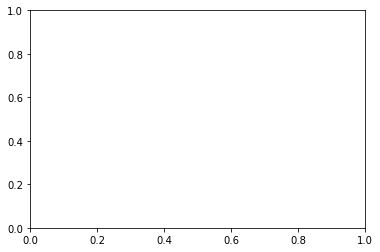

In [62]:
sikeys = list(ds_dict.keys())
okeys = list(ds_dict2.keys())

for n in np.arange(len(sikeys)):
    ds = ds_dict[sikeys[n]].squeeze()
    ds2 = ds_dict2[okeys[n]].squeeze()
    siconc = ds['siconc'][-312:, :76, :]
    areacell = ds2['areacello'][:76, :]
    
    siarea = siconc*areacell
    
    siarea_tseries = np.sum(siarea, axis=(1, 2))
    
    siarea_tseries.plot()
    
    

In [61]:
siarea_tseries

<xarray.DataArray (time: 312)>
dask.array<sum-aggregate, shape=(312,), dtype=float32, chunksize=(180,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) object 1989-01-16 12:00:00 ... 2014-12-16 12:00:00
    member_id  <U8 'r1i1p1f1'